<a href="https://colab.research.google.com/github/Joaogmr472/GLM/blob/main/C%C3%B3digo_3_plota_espacial_glm_ELISA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GOES-16: REDE GLM (PARTE III)**
**Plota mapas de flashes do GLM (GOES-16) para o Brasil**

---
**OBJETIVO:** Este Google Colab plota mapas **anual**, **mensal** e **sazonal** para o Brasil de flashes do GLM.

**DADOS DE ENTRADA**: Dados de flashes do GOES-16. 
Dados de flashes diários gerados a partir dos dados do CPTEC. Estão na pasta **output** do drive.. **Nome:** flash_diario_goes16_2021-01.nc. 
---
**DADOS DE SAÍDA:**
1.   Mapa **anual** de flash. 
2.   Mapa **mensal** de flash. 
3.   Mapa **sazonal** de flash. 
---
**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Importação das bibliotecas
3.   Monta o drive da pessoa
4.   Processa o dado diário
4.   Plota as Figuras
 
---
**OBSERVAÇÕES IMPORTANTES**: 
1. Mudar o caminho para seu drive. Veja em: **###MUDANÇAS AQUI####**
---
***Realizado por: [João G M Ribeiro](https://github.com/Joaogmr472/) e [Enrique V Mattos](https://github.com/evmpython) - 17/mar/2022*** 

# **###MUDANÇAS AQUI###**

- Insira o ano desejado

In [ ]:
ano = '2021'

- Insira o caminho do seu drive

In [ ]:
# Pasta com os dados Horários
path = f'/content/drive/MyDrive/JOAO_GABRIEL_MESTRADO/MESTRADO/DADOS/GLM/DADOS_diario/{ano}/'
# Pasta para a Saída das Figuras
path_fig = f'/content/drive/MyDrive/JOAO_GABRIEL_MESTRADO/MESTRADO/DADOS/GLM/figuras/'

# **Instalando as bibliotecas**

In [ ]:
# Instalando o cartopy (usado para gerar Mapas)
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install --no-binary shapely shapely --force
!pip install cartopy

# Instalando o proplot (usado para gerar Mapas também)
!pip install proplot==0.6.4

# Intalando pacote que descompacta arquivos .rar
!pip install patool pyunpack

# Instalando o Salem (usado para mascarar regiões)
!pip install rasterio
!pip install pyproj
!pip install geopandas
!pip install salem
print('\n')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (110 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state 

# **Importa as bibliotecas**

In [ ]:
import xarray as xr
import proplot as plot
import time as t
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm_notebook
import glob
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import os
from time import process_time
import calendar
import salem
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


# **Monta Drive**

In [ ]:
# acessando o drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Download de informações auxiliares**

In [ ]:
# Baixando os arquivos de shapefile dos estados brasileiros
!wget -c https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_UF_2020.zip

# descompacta o shapefile
!unzip -o /content/BR_UF_2020.zip


--2022-03-16 12:28:16--  https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2020/Brasil/BR/BR_UF_2020.zip
Resolving geoftp.ibge.gov.br (geoftp.ibge.gov.br)... 191.233.136.86
Connecting to geoftp.ibge.gov.br (geoftp.ibge.gov.br)|191.233.136.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13793582 (13M) [application/zip]
Saving to: ‘BR_UF_2020.zip’

BR_UF_2020.zip      100%[===================>]  13.15M  8.58MB/s    in 1.5s    

2022-03-16 12:28:18 (8.58 MB/s) - ‘BR_UF_2020.zip’ saved [13793582/13793582]

Archive:  /content/BR_UF_2020.zip
  inflating: BR_UF_2020.cpg          
  inflating: BR_UF_2020.dbf          
  inflating: BR_UF_2020.prj          
  inflating: BR_UF_2020.shp          
  inflating: BR_UF_2020.shx          


# **Importa funções**

In [ ]:
#----------------------------------------------------------------------------------- 
# Função que plota os Estados do Brasil
#----------------------------------------------------------------------------------- 
def evm_plot_states():
    shapefile = list(shpreader.Reader('/content/BR_UF_2020.shp').geometries()) ; ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='black',facecolor='none', linewidth=1.4)   


# **Latitudes e Longitudes limitantes do Brasil**

In [ ]:
# lats/lons do quadrado limitando o Brasil
latmin, latmax, lonmin, lonmax = -35, 7, -75, -32

# gera a mascara para ro Brasil
shp = salem.read_shapefile(f'{path_fig}UIA_World_Countries_Boundaries/World_Countries__Generalized_.shp')
shp_br = shp.loc[shp['COUNTRY'] == 'Brazil']

# **Plota a Figura Mensal**

PROCESSANDO MÊS --->>> 01
PROCESSANDO MÊS --->>> 02
PROCESSANDO MÊS --->>> 03
PROCESSANDO MÊS --->>> 04
PROCESSANDO MÊS --->>> 05
PROCESSANDO MÊS --->>> 06
PROCESSANDO MÊS --->>> 07
PROCESSANDO MÊS --->>> 08
PROCESSANDO MÊS --->>> 09
PROCESSANDO MÊS --->>> 10
PROCESSANDO MÊS --->>> 11
PROCESSANDO MÊS --->>> 12


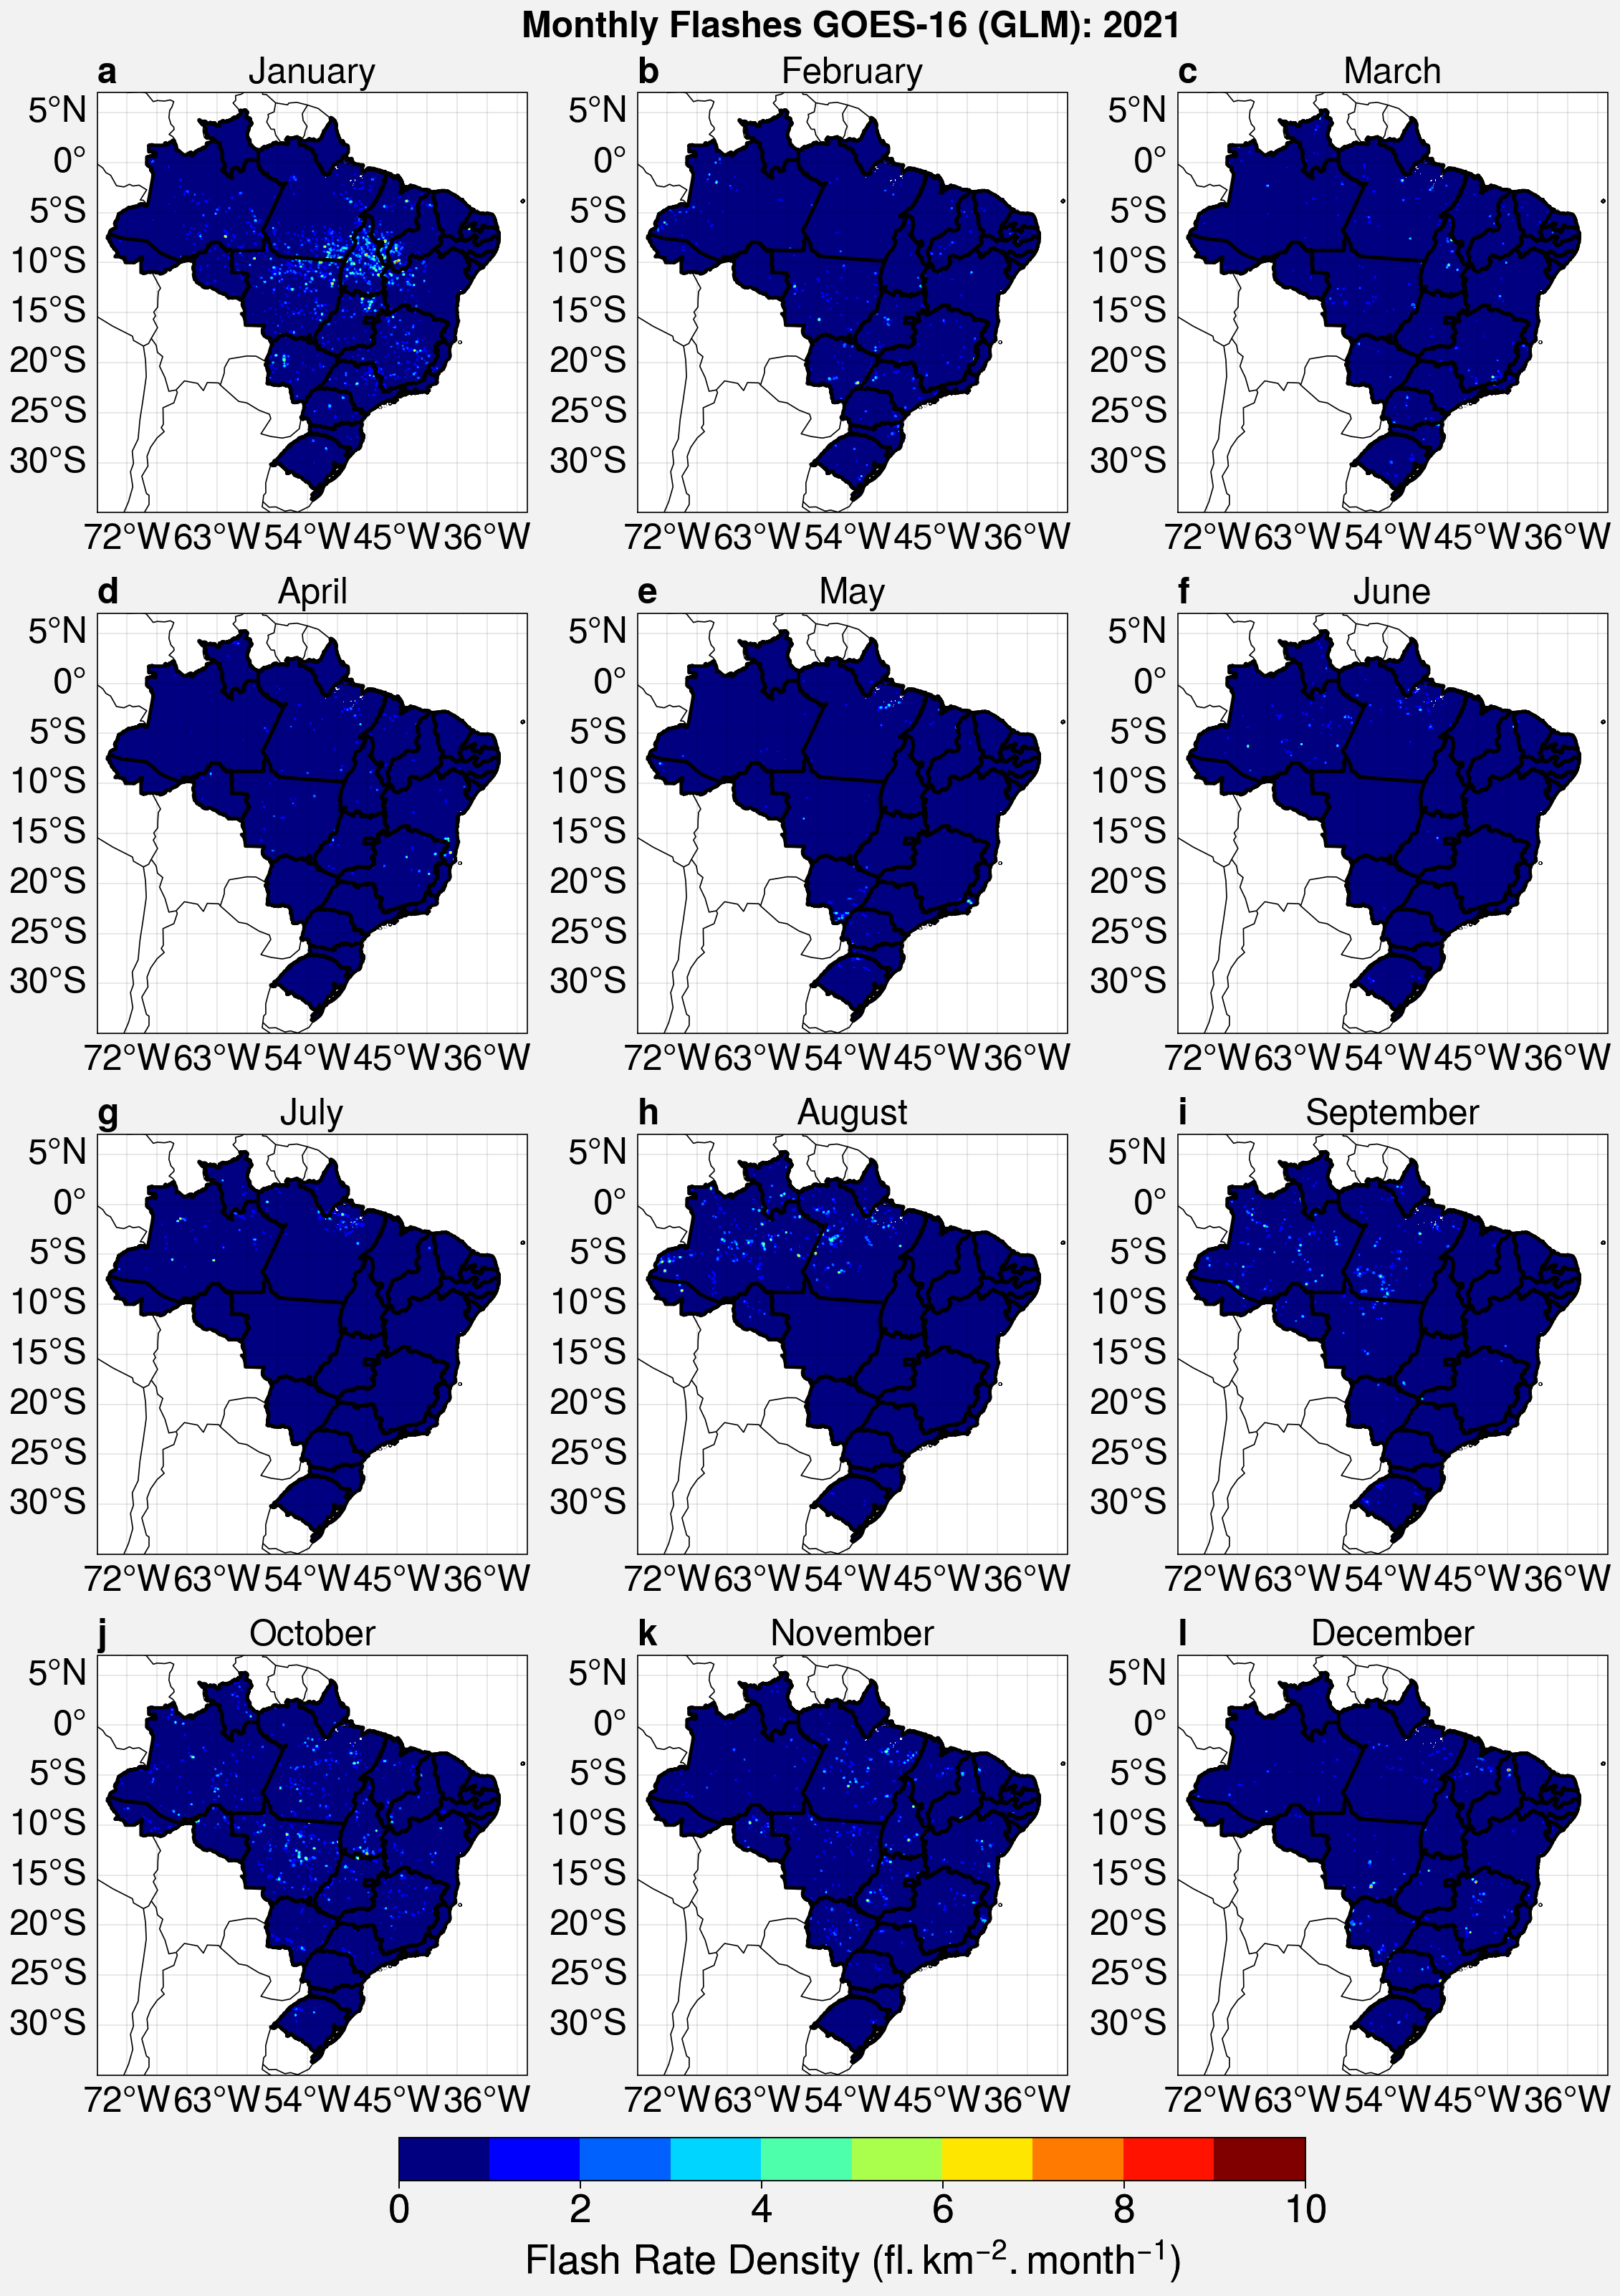

In [ ]:
# cria a moldura da figura   
fig, ax = plot.subplots(axwidth=3, axheight=3, ncols=3, nrows=4, tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=True, labels=True, latlines=5, lonlines=3,
          suptitle=f'Monthly Flashes GOES-16 (GLM): {ano}', 
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax), fontsize=11, 
          abc='(A)', small='25px', large='25px')

# plota estados
evm_plot_states()

soma_mens = np.zeros((12,1664,1664))

# loop dos meses
for i in range(0, 12):
  
  mes = str(i+1).zfill(2)
  
  print('PROCESSANDO MÊS --->>>', mes)
    
  # loop dos arquivos daquele mês
  soma_mes = np.zeros((1664,1664))
  for file in glob.glob(f'{path}flash_diario_goes16_{ano}-{mes}-*nc'):
    # leitura do arquivo netcdf
    dados = xr.open_dataset(file)   
    dados = dados.salem.roi(shape=shp_br)
    # somando os flashes                   
    soma_mes = soma_mes + dados['flash'][0,:,:]

  # plota figura
  if i == 0: 
    #.salem.roi(shape=shp_br)
    map1 = ax[i].contourf(soma_mes['lon'], soma_mes['lat'], (soma_mes/64.), cmap='jet', levels=plot.arange(0., 10, 1))
  else:
    ax[i].contourf(soma_mes['lon'], soma_mes['lat'], (soma_mes/64.), cmap='jet', levels=plot.arange(0., 10, 1)) 
        
  # plota titulo de cada figura
  ax[i].format(title=calendar.month_name[int(mes)])

  soma_mens[i,:,:] = soma_mes[:,:] 

# plota barra de cores da figura
fig.colorbar(map1, loc='b', label='Flash Rate Density $(fl.km^{-2}.month^{-1})$', ticks=2, ticklabelsize=20, labelsize=20, space=0.4, length=0.60, width=0.3)

# salva figura
fig.save(f'{path_fig}Fig1_glm_{ano}_mensal.jpg', dpi=300) 

#**Plota a Figura Anual**

In [ ]:
soma_mens.shape

(12, 1664, 1664)

In [ ]:
soma_anual = np.zeros((1664,1664))
for i in range(0,12):
  soma_anual = soma_anual + soma_mens[i,:,:]

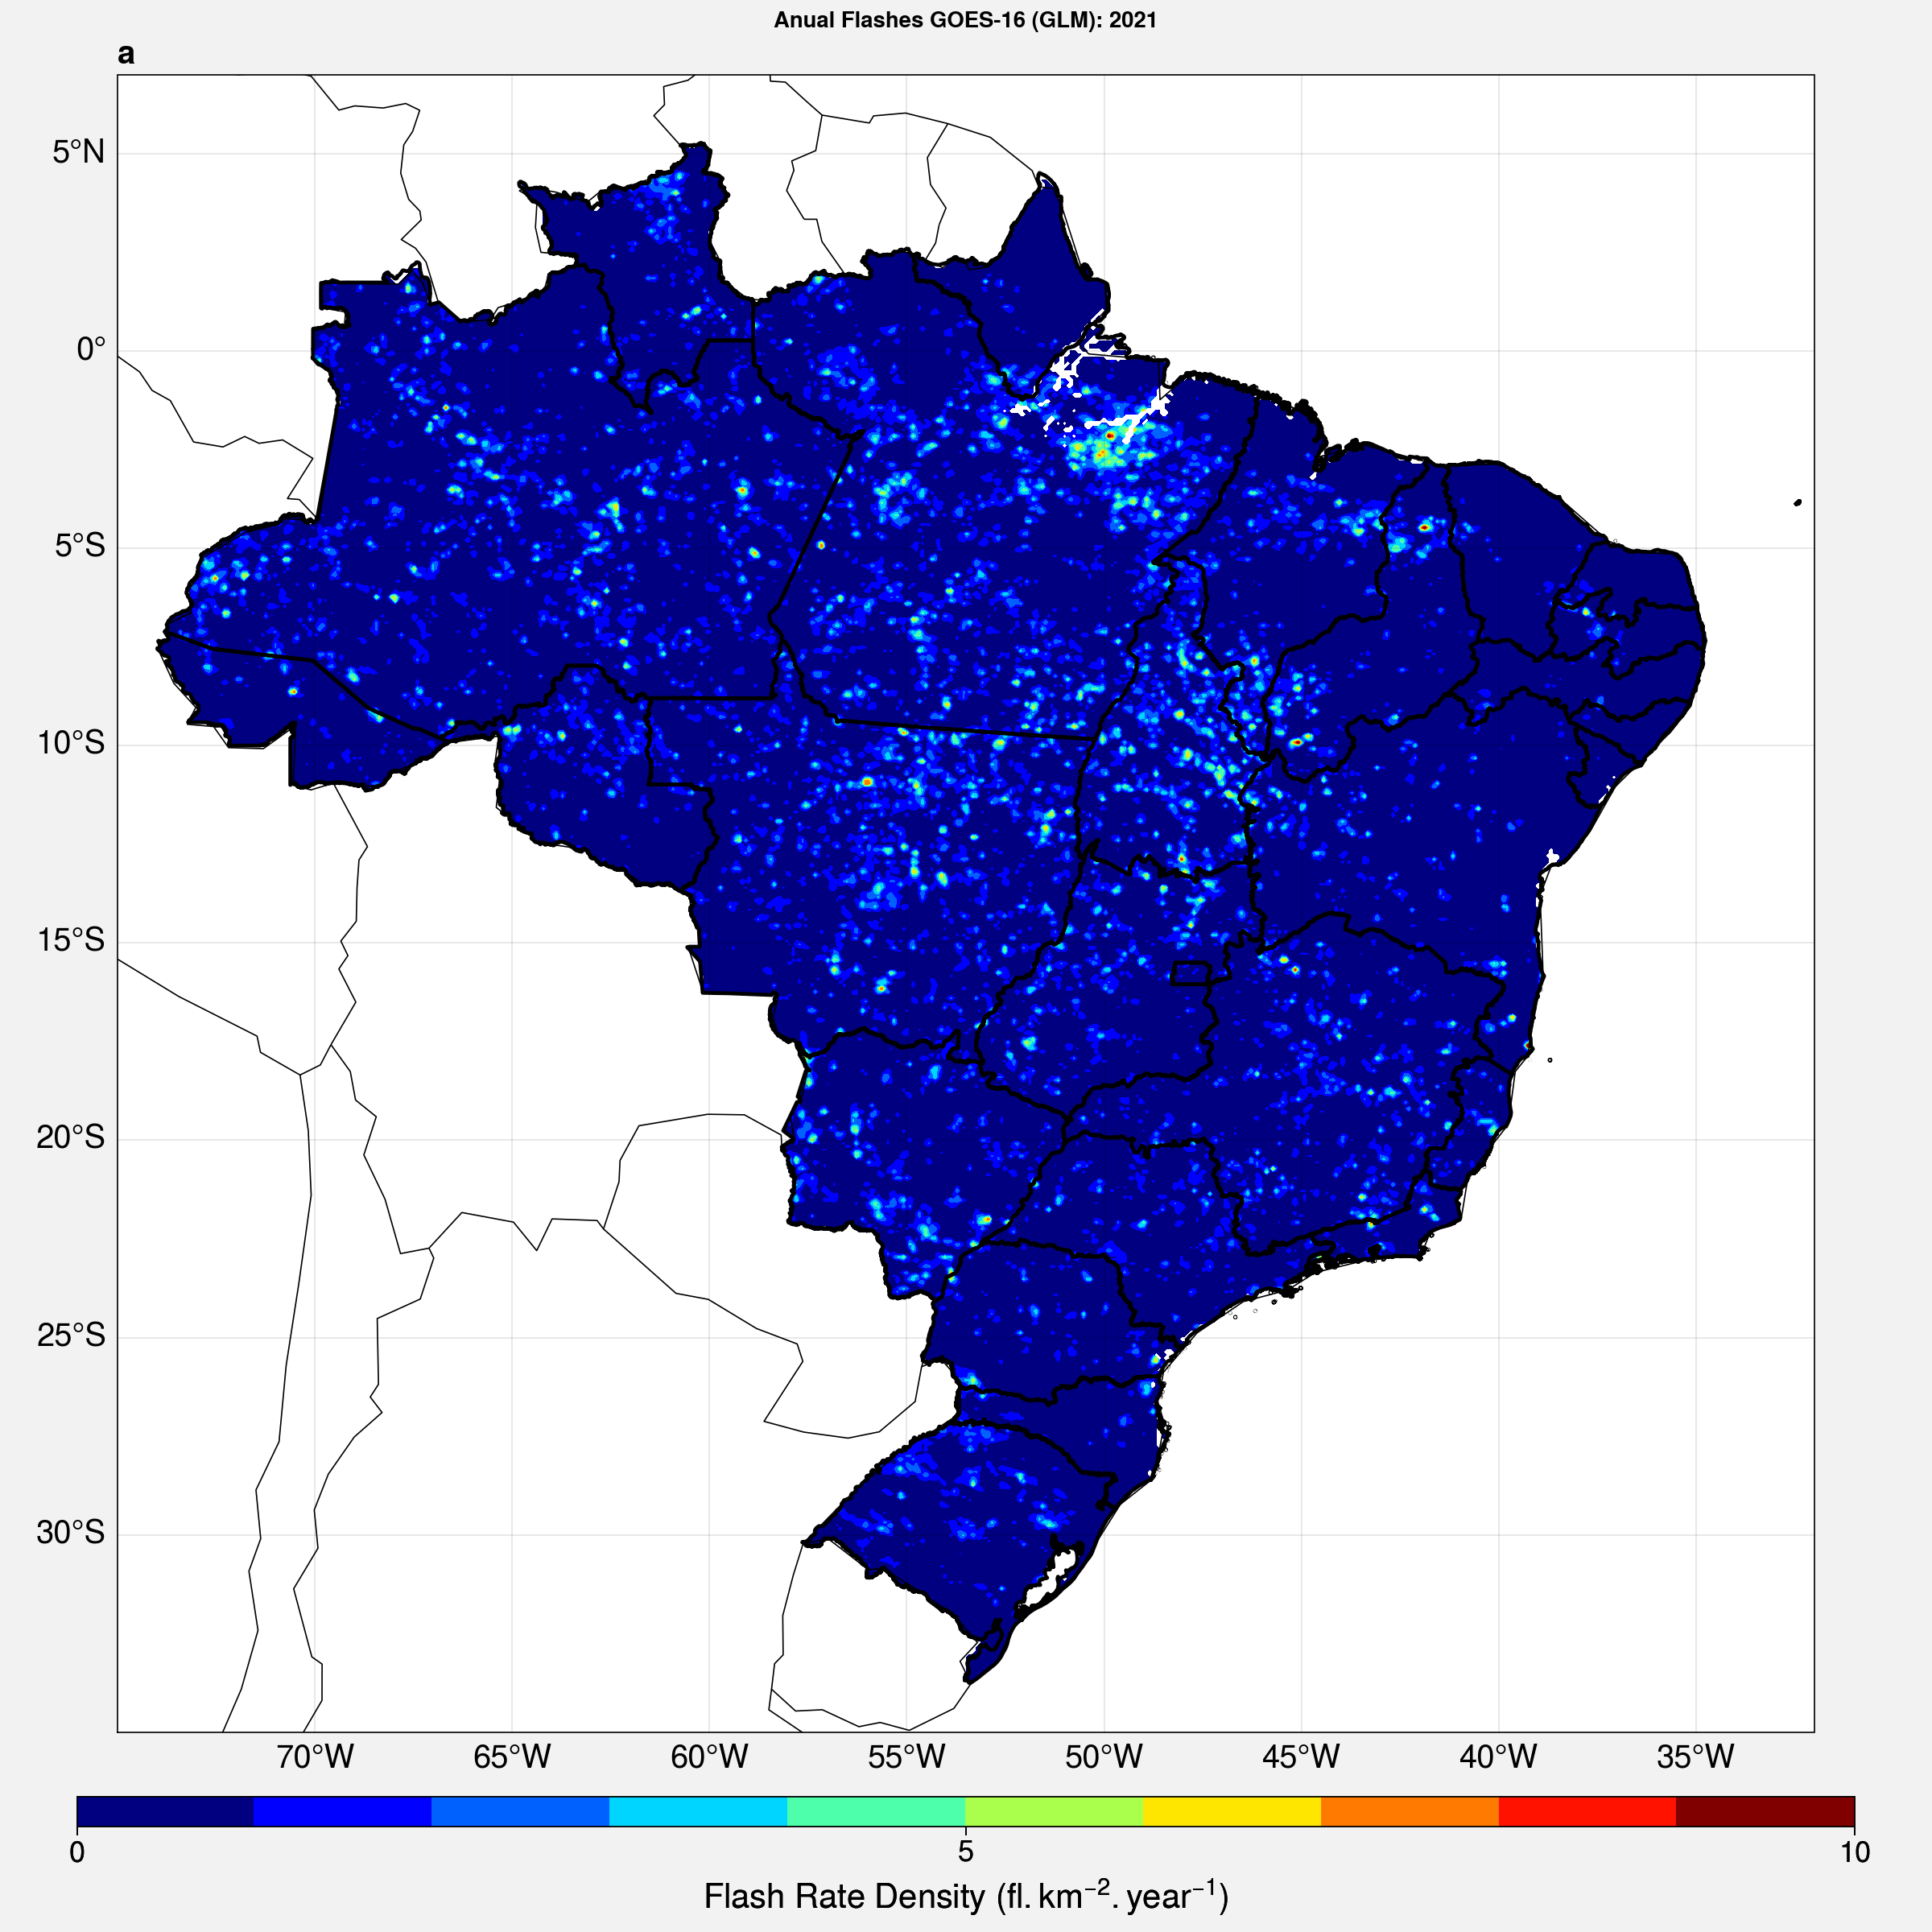

In [ ]:
# Plotando a figura
fig, ax = plot.subplots(figsize=(12,12), tight=True, proj='pcarree')

# define formato da figura
ax.format(coast=True, borders=True, innerborders=True, labels=True, latlines=5, lonlines=5,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax), fontsize=11, 
          suptitle=f'Anual Flashes GOES-16 (GLM): {ano}', small='20px', large='20px', abc=True)

# plota contornos dos Estados
evm_plot_states()

# Plota Figura Figura
map = ax.contourf(soma_mes['lon'], soma_mes['lat'], (soma_anual/64.), cmap='jet', levels=plot.arange(0., 10, 1))

# plota barra de cores da figura
fig.colorbar(map, loc='b', label='Flash Rate Density $(fl.km^{-2}.year^{-1})$', ticks=5, ticklabelsize=13, labelsize=15, space=0.4, length=0.93)

# salva figura
fig.save(f'{path_fig}/Fig2_glm_{ano}_anual.jpg', dpi=300)

#**Plota a Figura Sazonal**

In [ ]:
nome_estacoes = ['Summer', 'Autumn', 'Winter', 'Spring']

PROCESSANDO ESTAÇÃO --->>> 0
PROCESSANDO ESTAÇÃO --->>> 1
PROCESSANDO ESTAÇÃO --->>> 2
PROCESSANDO ESTAÇÃO --->>> 3


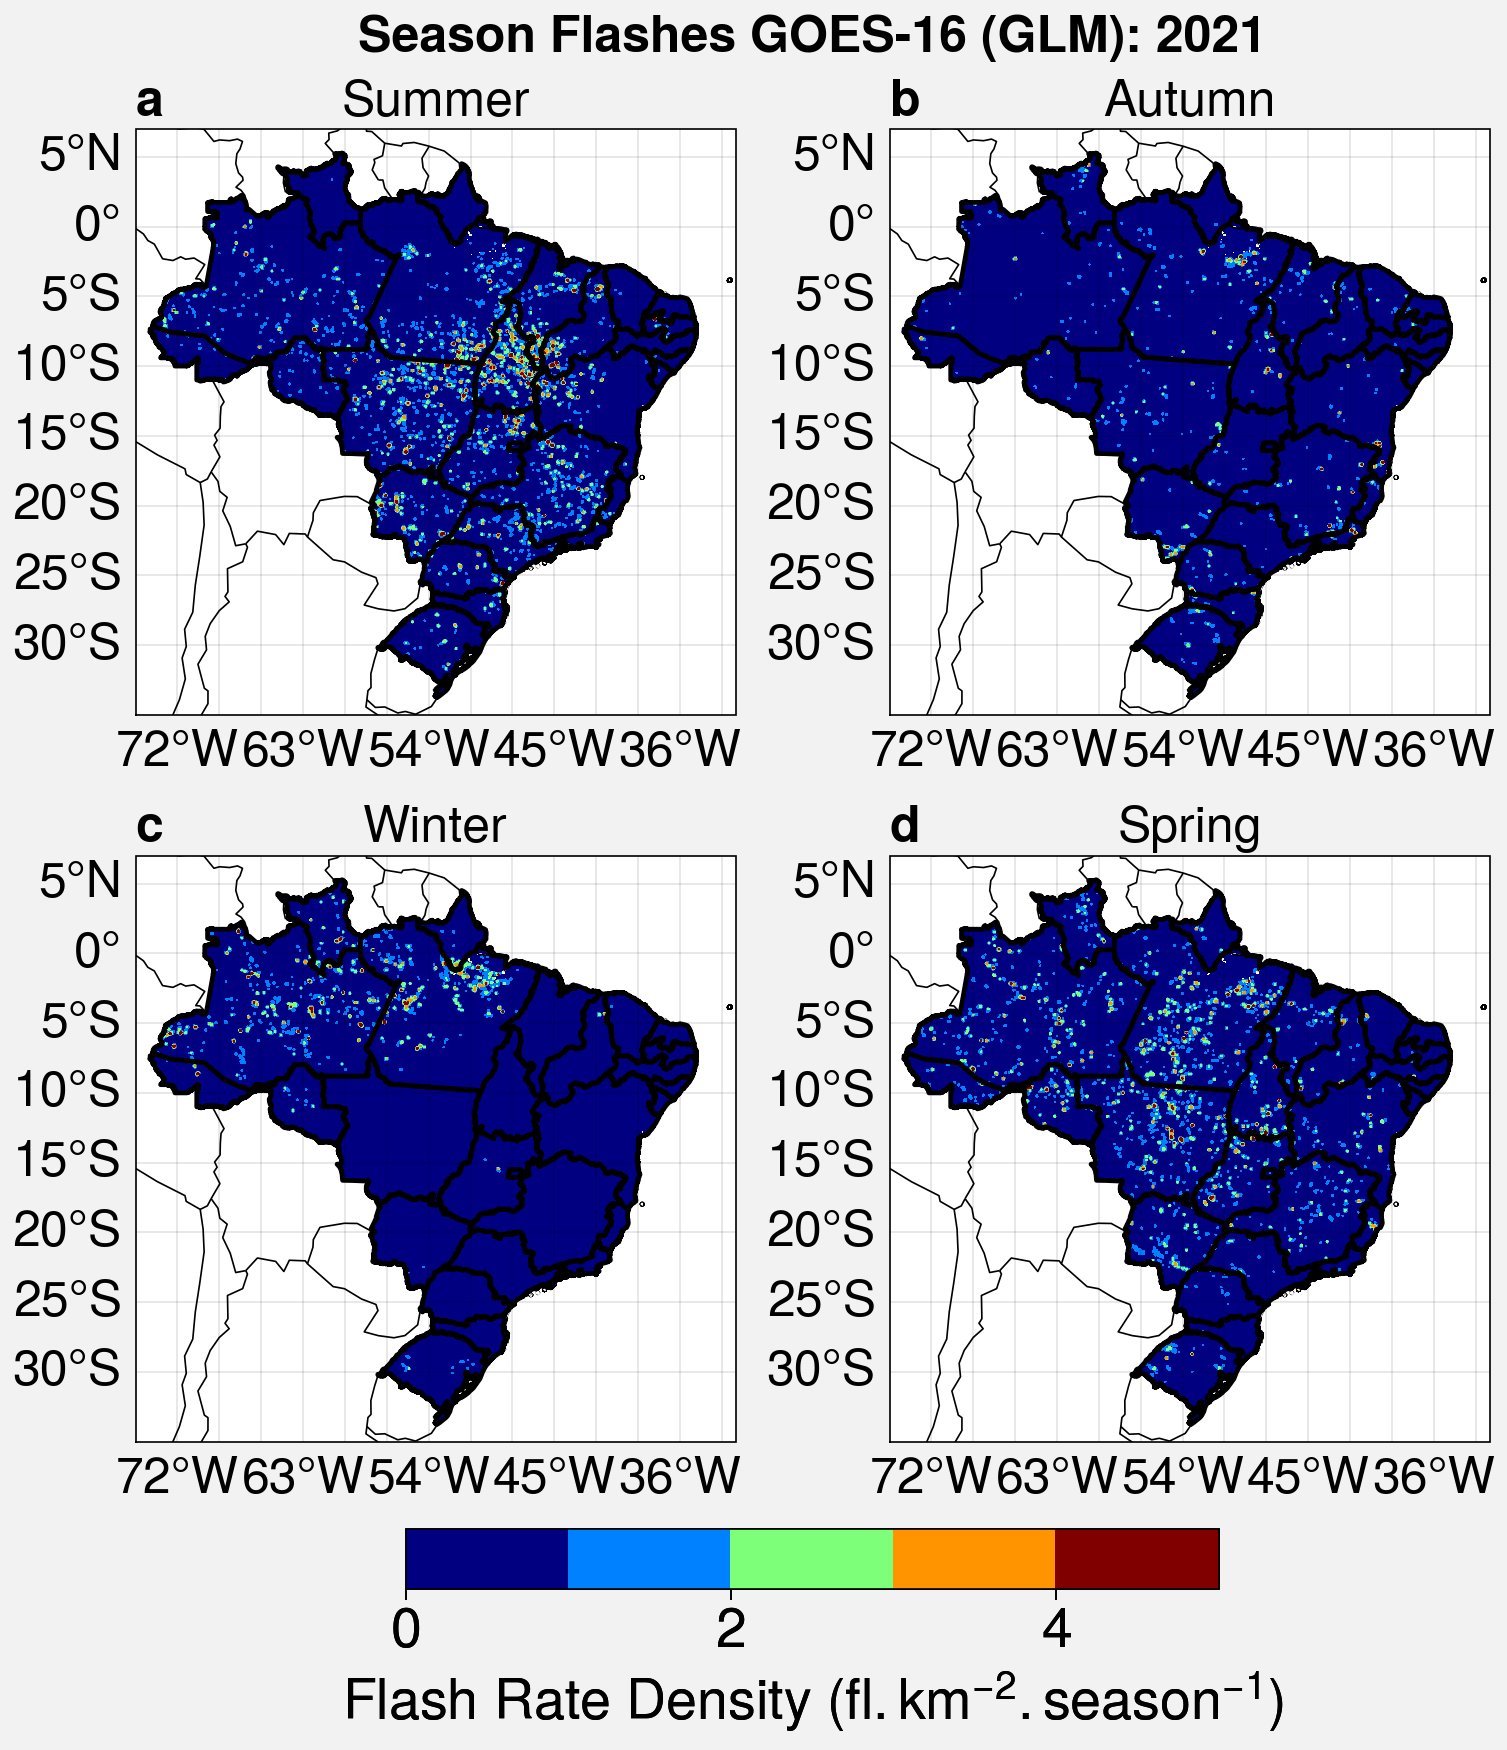

In [ ]:
# cria a moldura da figura   
fig, ax = plot.subplots(axwidth=3, axheight=3, ncols=2, nrows=2, tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=True, labels=True, latlines=5, lonlines=3,
          suptitle=f'Season Flashes GOES-16 (GLM): {ano}', 
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax), fontsize=11, 
          abc='(A)', small='25px', large='25px')

# plota estados
evm_plot_states()

# loop dos meses
for i in range(0, 4):
  
    print('PROCESSANDO ESTAÇÃO --->>>', i)
    
    # seleciona os meses para cada estação 
    if (i == 0): mes1, mes2, mes3 = '12', '01', '02'
    if (i == 1): mes1, mes2, mes3 = '03', '04', '05'
    if (i == 2): mes1, mes2, mes3 = '06', '07', '08'
    if (i == 3): mes1, mes2, mes3 = '09', '10', '11'

    # loop dos arquivos daquele mês
    files = glob.glob(f'{path}flash_diario_goes16_{ano}-{mes1}-*nc') + glob.glob(f'{path}flash_diario_goes16_{ano}-{mes2}-*nc') + glob.glob(f'{path}flash_diario_goes16_{ano}-{mes3}-*nc')
    soma_diego = np.zeros((1664,1664))
    for file in files:

        # leitura do arquivo netcdf
        dados = xr.open_dataset(file)   
        dados = dados.salem.roi(shape=shp_br)

        # somando os flashes                   
        soma_diego = soma_diego + dados['flash'][0,:,:]

    # plota figura
    if i == 0: 
        map1 = ax[i].contourf(soma_diego['lon'], soma_diego['lat'], (soma_diego/64.), cmap='jet', levels=plot.arange(0., 10, 1))
    else:
        ax[i].contourf(soma_diego['lon'], soma_diego['lat'], (soma_diego/64.), cmap='jet', levels=plot.arange(0., 10, 1)) 
        
    # plota titulo de cada figura
    ax[i].format(title=nome_estacoes[i])

# plota barra de cores da figura
fig.colorbar(map1, loc='b', label='Flash Rate Density $(fl.km^{-2}.season^{-1})$', ticks=2, ticklabelsize=20, labelsize=20, space=0.4, length=0.60, width=0.3)

# salva figura
fig.save(f'{path_fig}Fig3_glm_{ano}_sazonal.jpg', dpi=300) 